In [70]:
import pyPLS
%matplotlib inline

## Simulation of a few spectra

For the demo, a set of spectra is generated by simulation. **PCA** and **PLS** are then going to performed on these data. The function $simulation.simulateData$ requires a minimum of 4 parameters to generate the spectra:
- **n** is the number of spectra
- **ncp** is the number of latent variables 
- **p** is the number of measured variables
- **sigma** is the peak width
- **signalToNoise** is an optional parameter (default 100) for setting a level of noise in the data. The higher the value the lower is the noise.

In [2]:
X, Z, Y = pyPLS.simulateData(50, 5, 1000, 10., signalToNoise=50.0)

## PLS

pyPLS contains an implementation of noPLS1 and noPLS2. The classic PLS is also avaliable for comparison. Let's use the first column of the simulated Y to compare PLS amd noPLS.

In [3]:
noPLS = pyPLS.nopls2(X,Y[:,0], scaling=0., cvfold=7)
PLS = pyPLS.pls2(X, Y[:,0], 3, scaling=0., cvfold=7)

Now the summary of PLS and noPLS are compared: 

In [4]:
noPLS.summary()

----------------------
Summary of input table
----------------------
Observations: 50
Predictor Variables (X): 1000
Response Variables (Y): 1
Missing values in X: 0 (0.0%)
Missing values in Y: 0 (0.0%)
---------------
Summary of PLS:
---------------
Fitted using nopls2
Number of components: 2
Determination coefficient (R2Y): 0.994
Modeled variance in X: 0.728
Cross-validation:
Number of fold: 7
Cumulative Q2Y: 0.997


In [5]:
PLS.summary()

----------------------
Summary of input table
----------------------
Observations: 50
Predictor Variables (X): 1000
Response Variables (Y): 1
Missing values in X: 0 (0.0%)
Missing values in Y: 0 (0.0%)
---------------
Summary of PLS:
---------------
Fitted using pls2
Number of components: 3
Determination coefficient (R2Y): 0.998
Modeled variance in X: 0.79
Cross-validation:
Number of fold: 7
Cumulative Q2Y: 0.998


In [6]:
Xc, Xbar, Sx = pyPLS.preprocessing.scaling(X,0)
Yc, Ybar, Sy = pyPLS.preprocessing.scaling(Y,0)
XX = (Xc @ Xc.T)

In [7]:
import matplotlib.pyplot as plt
import numpy as np
D2 = np.linalg.matrix_power(XX, 3)
D1 = np.linalg.matrix_power(XX, 2)
DD = D2/np.max(D2) - D1/np.max(D1)
plt.imshow(DD)
cbar = plt.colorbar()
plt.show()

/Users/ocloarec/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


In [8]:
np.max(XX)

15683.229153830978

In [9]:
t1 = XX @ Yc[:,0]
t2 = XX @ XX @ Yc[:,0]
t3 = XX @ XX @ XX @ Yc[:,0]

In [10]:
t1 = t1 / np.sqrt(np.sum(t1**2))
t2 = t2 / np.sqrt(np.sum(t2**2))
t3 = t3 / np.sqrt(np.sum(t3**2))

In [11]:
plt.plot(t2,t3)
plt.show()

In [12]:
def proj(u, v):
    # notice: this algrithm assume denominator isn't zero
    return u * np.dot(v,u) / np.dot(u,u)  
 
def GS(V):
    V = 1.0 * V     # to float
    U = np.copy(V)
    for i in np.arange(1, V.shape[1]):
        for j in np.arange(i):
            U[:,i] -= proj(U[:,j], V[:,i])
    # normalize column
    den=(U**2).sum(axis=0) **0.5
    E = U/den
    # assert np.allclose(E.T, np.linalg.inv(E))
    return E

In [13]:
T = np.asarray([t1,t2,t2])

In [14]:
To, r = np.linalg.qr(T.T)

In [15]:
plt.plot(To[:,0], To[:,1], '.')
plt.show()

In [16]:
To.T @ To

array([[  1.00000000e+00,  -1.38777878e-17,   2.42861287e-17],
       [ -1.38777878e-17,   1.00000000e+00,   1.24900090e-16],
       [  2.42861287e-17,   1.24900090e-16,   1.00000000e+00]])

In [17]:
To.shape

(50, 3)

In [18]:
plt.plot(To[:,1], Y[:,0], '.')
plt.show()

In [19]:
c = To.T @ Yc[:,0]

In [20]:
plt.plot(To @ c, Yc[:,0], '.')
plt.show()

In [34]:
def diagonal_correction(ZZ, v, n):
    correction = np.zeros((n, n))
    H = (np.eye(n) - np.ones((n, n), dtype=float)/n)
    for i, zz in enumerate(ZZ):
        zzw = np.delete(zz, i)
        zzwc = zzw - np.mean(zzw)
        vw = np.delete(v, i)
        a = np.inner(zzwc, vw)/np.sum(vw**2)
        b = np.mean(zzw) - a * np.mean(vw)
        zzihat = v[i]*a + b
        correction[i, i] = zz[i] - zzihat

    ZZ = ZZ - correction
    # ZZ is then recentred
    ZZ = H.T @ ZZ @ H
    return ZZ

In [129]:
X, Z, Y = pyPLS.simulateData(50, 5, 1000, 10., signalToNoise=100.0)

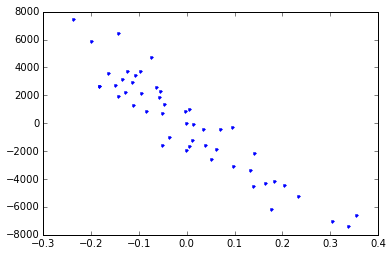

In [130]:
Xc, Xbar, Sx = pyPLS.preprocessing.scaling(X,0)
Yc, Ybar, Sy = pyPLS.preprocessing.scaling(Y,0)
XX = (Xc @ Xc.T)
u, s, v = np.linalg.svd(XX)
plt.plot(u[:,0], XX[:,0],'.')
plt.show()

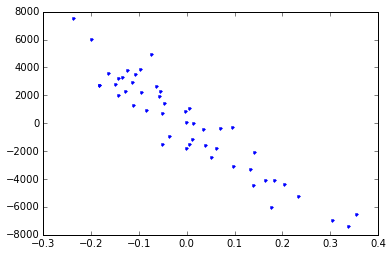

In [131]:
XX1 = diagonal_correction(XX, u[:,0], 50)
plt.plot(u[:,0], XX1[:,0],'.')
plt.show()

In [132]:
u1, s1, v1 = np.linalg.svd(XX1)

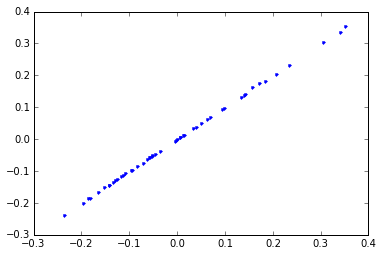

In [133]:
plt.plot(u1[:,0], u[:,0],'.')
plt.show()

In [134]:
P = Xc.T @ u1[:,0:49] 
Xr = u1[:,0:49] @ P.T

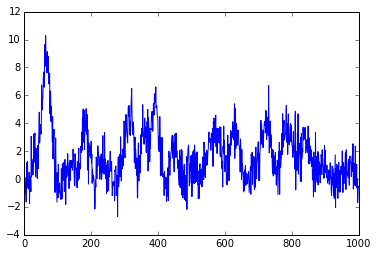

In [135]:
# plt.plot(np.arange(0,1000), X[0,:])
i = 0
for i in np.arange(1):
    plt.plot(np.arange(0,1000), Xr[i,:])
plt.show()

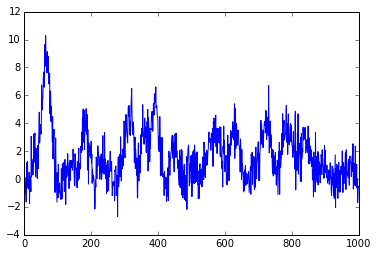

In [136]:
i = 0
for i in np.arange(1):
    plt.plot(np.arange(0,1000), Xc[i,:])
plt.show()